## Import Modules

In [1]:
# Import all the required modules
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

if 'google.colab' in sys.modules:
    # Download the repo from GitHub
    print("Downloading repository on Colab...")
    !git clone https://github.com/Shilpaj1994/ERA.git

    # Import files from the downloaded repository
    sys.path.insert(0,'./ERA/Session9/')

Cloning into 'ERA'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 166 (delta 59), reused 147 (delta 40), pack-reused 0
Receiving objects: 100% (166/166), 4.01 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (59/59), done.


# Dataset Analysis

## Extract and Load the Data

In [2]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49064699.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


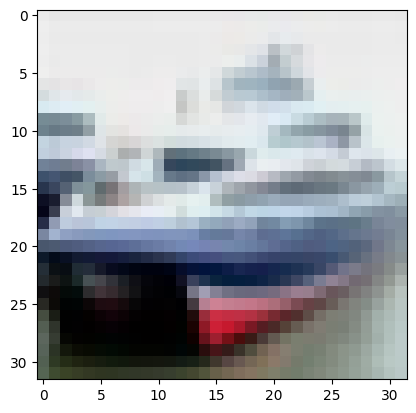

In [3]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Parameters

In [4]:
BATCH_SIZE = 512
EPOCHS = 100
DISPLAY_SAMPLES = 20
LEARNING_RATE = 0.112
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1
STEPS_PER_EPOCH = math.ceil(50_000/BATCH_SIZE)

## Visualize Training Data

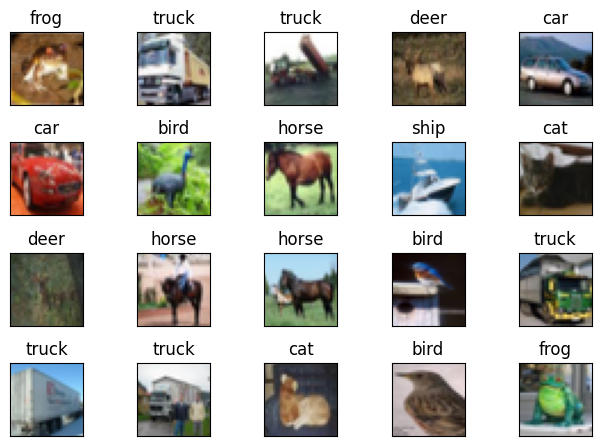

In [5]:
from visualize import display_cifar_data_samples

sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

## Transformations

In [6]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=0.2),
    'horizontalflip': A.HorizontalFlip(),
    'rotation': A.Rotate(15),
    'shiftscalerotate': A.ShiftScaleRotate(),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

In [7]:
from datasets import AlbumDataset

train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


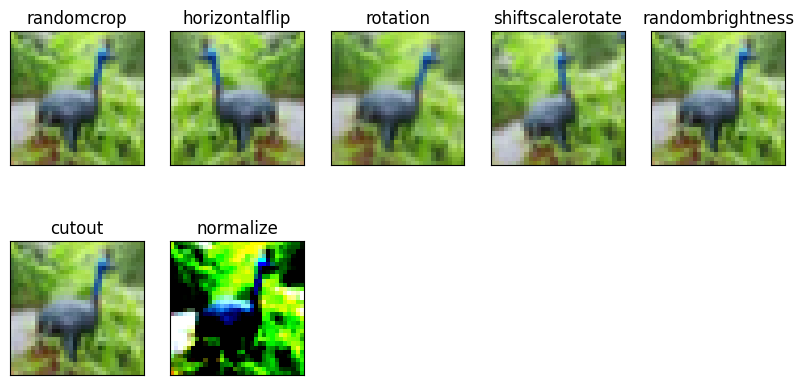

In [8]:
from visualize import visualize_cifar_augmentation

aug_train = AlbumDataset('./data', train=True, download=True)

visualize_cifar_augmentation(aug_train, train_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [9]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [10]:
from model import Session9Net
from utils import get_summary

get_summary(Session9Net(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6           [-1, 32, 34, 34]           1,024
              ReLU-7           [-1, 32, 34, 34]               0
       BatchNorm2d-8           [-1, 32, 34, 34]              64
           Dropout-9           [-1, 32, 34, 34]               0
           Conv2d-10           [-1, 32, 16, 16]           9,216
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 40,

## Model Training and Testing

In [11]:
from training_utils import train, test

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


# Put the model on selected device
model = Session9Net().to(device)

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# New Line
criterion = F.nll_loss

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.7975 Batch_id=97 Accuracy=21.45: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


Test set: Average loss: 1.7413, Accuracy: 3538/10000 (35.38%)

Epoch 2


Train: Loss=1.5830 Batch_id=97 Accuracy=35.21: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


Test set: Average loss: 1.4835, Accuracy: 4480/10000 (44.80%)

Epoch 3


Train: Loss=1.5828 Batch_id=97 Accuracy=40.92: 100%|██████████| 98/98 [00:11<00:00,  8.85it/s]


Test set: Average loss: 1.3512, Accuracy: 5033/10000 (50.33%)

Epoch 4


Train: Loss=1.5145 Batch_id=97 Accuracy=44.85: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 1.2689, Accuracy: 5374/10000 (53.74%)

Epoch 5


Train: Loss=1.3845 Batch_id=97 Accuracy=46.85: 100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


Test set: Average loss: 1.2147, Accuracy: 5609/10000 (56.09%)

Epoch 6


Train: Loss=1.3799 Batch_id=97 Accuracy=49.08: 100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


Test set: Average loss: 1.1548, Accuracy: 5854/10000 (58.54%)

Epoch 7


Train: Loss=1.2461 Batch_id=97 Accuracy=51.20: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


Test set: Average loss: 1.0879, Accuracy: 6179/10000 (61.79%)

Epoch 8


Train: Loss=1.2383 Batch_id=97 Accuracy=52.68: 100%|██████████| 98/98 [00:10<00:00,  9.50it/s]


Test set: Average loss: 1.0707, Accuracy: 6215/10000 (62.15%)

Epoch 9


Train: Loss=1.2123 Batch_id=97 Accuracy=53.74: 100%|██████████| 98/98 [00:09<00:00, 10.15it/s]


Test set: Average loss: 0.9864, Accuracy: 6504/10000 (65.04%)

Epoch 10


Train: Loss=1.2860 Batch_id=97 Accuracy=55.85: 100%|██████████| 98/98 [00:10<00:00,  9.46it/s]


Test set: Average loss: 0.9631, Accuracy: 6625/10000 (66.25%)

Epoch 11


Train: Loss=1.3054 Batch_id=97 Accuracy=57.07: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


Test set: Average loss: 0.9929, Accuracy: 6551/10000 (65.51%)

Epoch 12


Train: Loss=1.2154 Batch_id=97 Accuracy=57.94: 100%|██████████| 98/98 [00:10<00:00,  9.20it/s]


Test set: Average loss: 0.8920, Accuracy: 6871/10000 (68.71%)

Epoch 13


Train: Loss=1.0440 Batch_id=97 Accuracy=59.46: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.8388, Accuracy: 7060/10000 (70.60%)

Epoch 14


Train: Loss=1.1280 Batch_id=97 Accuracy=60.36: 100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


Test set: Average loss: 0.8391, Accuracy: 7036/10000 (70.36%)

Epoch 15


Train: Loss=1.0707 Batch_id=97 Accuracy=61.07: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Test set: Average loss: 0.8446, Accuracy: 7090/10000 (70.90%)

Epoch 16


Train: Loss=1.1165 Batch_id=97 Accuracy=62.09: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 0.7762, Accuracy: 7266/10000 (72.66%)

Epoch 17


Train: Loss=1.0069 Batch_id=97 Accuracy=62.57: 100%|██████████| 98/98 [00:10<00:00,  9.66it/s]


Test set: Average loss: 0.7665, Accuracy: 7345/10000 (73.45%)

Epoch 18


Train: Loss=1.0242 Batch_id=97 Accuracy=63.27: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.7304, Accuracy: 7473/10000 (74.73%)

Epoch 19


Train: Loss=1.1195 Batch_id=97 Accuracy=63.83: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s]


Test set: Average loss: 0.8029, Accuracy: 7246/10000 (72.46%)

Epoch 20


Train: Loss=0.9819 Batch_id=97 Accuracy=64.22: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


Test set: Average loss: 0.7060, Accuracy: 7567/10000 (75.67%)

Epoch 21


Train: Loss=0.9563 Batch_id=97 Accuracy=64.87: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


Test set: Average loss: 0.6937, Accuracy: 7588/10000 (75.88%)

Epoch 22


Train: Loss=0.9864 Batch_id=97 Accuracy=64.80: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.7058, Accuracy: 7566/10000 (75.66%)

Epoch 23


Train: Loss=0.9942 Batch_id=97 Accuracy=65.53: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s]


Test set: Average loss: 0.6831, Accuracy: 7622/10000 (76.22%)

Epoch 24


Train: Loss=1.1161 Batch_id=97 Accuracy=65.29: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.7424, Accuracy: 7495/10000 (74.95%)

Epoch 25


Train: Loss=0.8879 Batch_id=97 Accuracy=66.46: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.6631, Accuracy: 7687/10000 (76.87%)

Epoch 26


Train: Loss=0.8539 Batch_id=97 Accuracy=66.87: 100%|██████████| 98/98 [00:10<00:00,  9.61it/s]


Test set: Average loss: 0.6690, Accuracy: 7668/10000 (76.68%)

Epoch 27


Train: Loss=0.8738 Batch_id=97 Accuracy=67.18: 100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Test set: Average loss: 0.6238, Accuracy: 7840/10000 (78.40%)

Epoch 28


Train: Loss=0.9494 Batch_id=97 Accuracy=67.50: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s]


Test set: Average loss: 0.6691, Accuracy: 7696/10000 (76.96%)

Epoch 29


Train: Loss=1.0397 Batch_id=97 Accuracy=67.58: 100%|██████████| 98/98 [00:10<00:00,  8.95it/s]


Test set: Average loss: 0.6315, Accuracy: 7831/10000 (78.31%)

Epoch 30


Train: Loss=0.9523 Batch_id=97 Accuracy=67.81: 100%|██████████| 98/98 [00:10<00:00,  9.15it/s]


Test set: Average loss: 0.6006, Accuracy: 7959/10000 (79.59%)

Epoch 31


Train: Loss=0.9432 Batch_id=97 Accuracy=68.02: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.6065, Accuracy: 7912/10000 (79.12%)

Epoch 32


Train: Loss=0.8699 Batch_id=97 Accuracy=68.38: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s]


Test set: Average loss: 0.6054, Accuracy: 7948/10000 (79.48%)

Epoch 33


Train: Loss=0.9995 Batch_id=97 Accuracy=68.43: 100%|██████████| 98/98 [00:10<00:00,  9.15it/s]


Test set: Average loss: 0.5890, Accuracy: 8005/10000 (80.05%)

Epoch 34


Train: Loss=0.9324 Batch_id=97 Accuracy=68.61: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


Test set: Average loss: 0.5935, Accuracy: 7996/10000 (79.96%)

Epoch 35


Train: Loss=0.8428 Batch_id=97 Accuracy=68.54: 100%|██████████| 98/98 [00:09<00:00,  9.89it/s]


Test set: Average loss: 0.5941, Accuracy: 7977/10000 (79.77%)

Epoch 36


Train: Loss=0.9392 Batch_id=97 Accuracy=68.71: 100%|██████████| 98/98 [00:09<00:00,  9.90it/s]


Test set: Average loss: 0.5740, Accuracy: 8028/10000 (80.28%)

Epoch 37


Train: Loss=0.9249 Batch_id=97 Accuracy=69.01: 100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


Test set: Average loss: 0.5746, Accuracy: 8052/10000 (80.52%)

Epoch 38


Train: Loss=0.7840 Batch_id=97 Accuracy=69.36: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s]


Test set: Average loss: 0.5655, Accuracy: 8060/10000 (80.60%)

Epoch 39


Train: Loss=0.8327 Batch_id=97 Accuracy=69.56: 100%|██████████| 98/98 [00:10<00:00,  9.13it/s]


Test set: Average loss: 0.5809, Accuracy: 8045/10000 (80.45%)

Epoch 40


Train: Loss=0.8517 Batch_id=97 Accuracy=69.82: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.5790, Accuracy: 8049/10000 (80.49%)

Epoch 41


Train: Loss=1.0139 Batch_id=97 Accuracy=69.61: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.5888, Accuracy: 8008/10000 (80.08%)

Epoch 42


Train: Loss=0.8927 Batch_id=97 Accuracy=70.23: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 0.5732, Accuracy: 8077/10000 (80.77%)

Epoch 43


Train: Loss=0.8477 Batch_id=97 Accuracy=70.26: 100%|██████████| 98/98 [00:10<00:00,  9.50it/s]


Test set: Average loss: 0.6005, Accuracy: 7973/10000 (79.73%)

Epoch 44


Train: Loss=0.8442 Batch_id=97 Accuracy=70.27: 100%|██████████| 98/98 [00:09<00:00, 10.15it/s]


Test set: Average loss: 0.5751, Accuracy: 8058/10000 (80.58%)

Epoch 45


Train: Loss=0.8486 Batch_id=97 Accuracy=70.57: 100%|██████████| 98/98 [00:12<00:00,  7.97it/s]


Test set: Average loss: 0.5661, Accuracy: 8093/10000 (80.93%)

Epoch 46


Train: Loss=0.8264 Batch_id=97 Accuracy=70.62: 100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Test set: Average loss: 0.5569, Accuracy: 8085/10000 (80.85%)

Epoch 47


Train: Loss=0.8361 Batch_id=97 Accuracy=70.75: 100%|██████████| 98/98 [00:10<00:00,  9.15it/s]


Test set: Average loss: 0.5766, Accuracy: 8029/10000 (80.29%)

Epoch 48


Train: Loss=0.8978 Batch_id=97 Accuracy=70.91: 100%|██████████| 98/98 [00:10<00:00,  9.00it/s]


Test set: Average loss: 0.5433, Accuracy: 8160/10000 (81.60%)

Epoch 49


Train: Loss=0.8280 Batch_id=97 Accuracy=70.91: 100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


Test set: Average loss: 0.5322, Accuracy: 8210/10000 (82.10%)

Epoch 50


Train: Loss=0.7779 Batch_id=97 Accuracy=70.95: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Test set: Average loss: 0.5462, Accuracy: 8133/10000 (81.33%)

Epoch 51


Train: Loss=0.8124 Batch_id=97 Accuracy=71.28: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


Test set: Average loss: 0.5150, Accuracy: 8281/10000 (82.81%)

Epoch 52


Train: Loss=0.8060 Batch_id=97 Accuracy=71.49: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s]


Test set: Average loss: 0.5464, Accuracy: 8133/10000 (81.33%)

Epoch 53


Train: Loss=0.8587 Batch_id=97 Accuracy=71.72: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 0.5429, Accuracy: 8176/10000 (81.76%)

Epoch 54


Train: Loss=0.8094 Batch_id=97 Accuracy=71.56: 100%|██████████| 98/98 [00:09<00:00,  9.81it/s]


Test set: Average loss: 0.5231, Accuracy: 8216/10000 (82.16%)

Epoch 55


Train: Loss=0.7987 Batch_id=97 Accuracy=71.72: 100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Test set: Average loss: 0.5456, Accuracy: 8150/10000 (81.50%)

Epoch 56


Train: Loss=0.8863 Batch_id=97 Accuracy=71.84: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


Test set: Average loss: 0.5204, Accuracy: 8225/10000 (82.25%)

Epoch 57


Train: Loss=0.7097 Batch_id=97 Accuracy=72.00: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s]


Test set: Average loss: 0.5296, Accuracy: 8223/10000 (82.23%)

Epoch 58


Train: Loss=0.8446 Batch_id=97 Accuracy=72.31: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s]


Test set: Average loss: 0.5185, Accuracy: 8234/10000 (82.34%)

Epoch 59


Train: Loss=0.8768 Batch_id=97 Accuracy=72.13: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]


Test set: Average loss: 0.5020, Accuracy: 8307/10000 (83.07%)

Epoch 60


Train: Loss=0.8293 Batch_id=97 Accuracy=72.01: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s]


Test set: Average loss: 0.4997, Accuracy: 8317/10000 (83.17%)

Epoch 61


Train: Loss=0.6571 Batch_id=97 Accuracy=72.20: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s]


Test set: Average loss: 0.5078, Accuracy: 8276/10000 (82.76%)

Epoch 62


Train: Loss=0.8352 Batch_id=97 Accuracy=72.33: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.5030, Accuracy: 8312/10000 (83.12%)

Epoch 63


Train: Loss=0.6654 Batch_id=97 Accuracy=72.93: 100%|██████████| 98/98 [00:09<00:00,  9.85it/s]


Test set: Average loss: 0.5193, Accuracy: 8216/10000 (82.16%)

Epoch 64


Train: Loss=0.8178 Batch_id=97 Accuracy=72.55: 100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


Test set: Average loss: 0.4941, Accuracy: 8330/10000 (83.30%)

Epoch 65


Train: Loss=0.7479 Batch_id=97 Accuracy=72.74: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s]


Test set: Average loss: 0.5026, Accuracy: 8311/10000 (83.11%)

Epoch 66


Train: Loss=0.7441 Batch_id=97 Accuracy=72.85: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.5056, Accuracy: 8298/10000 (82.98%)

Epoch 67


Train: Loss=0.7846 Batch_id=97 Accuracy=73.00: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.5068, Accuracy: 8252/10000 (82.52%)

Epoch 68


Train: Loss=0.7107 Batch_id=97 Accuracy=73.33: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.4940, Accuracy: 8330/10000 (83.30%)

Epoch 69


Train: Loss=0.7558 Batch_id=97 Accuracy=73.33: 100%|██████████| 98/98 [00:10<00:00,  8.97it/s]


Test set: Average loss: 0.5043, Accuracy: 8323/10000 (83.23%)

Epoch 70


Train: Loss=0.8599 Batch_id=97 Accuracy=73.48: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.4971, Accuracy: 8346/10000 (83.46%)

Epoch 71


Train: Loss=0.7207 Batch_id=97 Accuracy=73.46: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s]


Test set: Average loss: 0.5019, Accuracy: 8328/10000 (83.28%)

Epoch 72


Train: Loss=0.6789 Batch_id=97 Accuracy=73.29: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Test set: Average loss: 0.4829, Accuracy: 8366/10000 (83.66%)

Epoch 73


Train: Loss=0.7889 Batch_id=97 Accuracy=73.56: 100%|██████████| 98/98 [00:09<00:00,  9.92it/s]


Test set: Average loss: 0.4761, Accuracy: 8381/10000 (83.81%)

Epoch 74


Train: Loss=0.8244 Batch_id=97 Accuracy=73.76: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


Test set: Average loss: 0.4659, Accuracy: 8416/10000 (84.16%)

Epoch 75


Train: Loss=0.8003 Batch_id=97 Accuracy=74.21: 100%|██████████| 98/98 [00:10<00:00,  8.97it/s]


Test set: Average loss: 0.4829, Accuracy: 8366/10000 (83.66%)

Epoch 76


Train: Loss=0.7256 Batch_id=97 Accuracy=73.97: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


Test set: Average loss: 0.4796, Accuracy: 8367/10000 (83.67%)

Epoch 77


Train: Loss=0.6865 Batch_id=97 Accuracy=74.38: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.4618, Accuracy: 8443/10000 (84.43%)

Epoch 78


Train: Loss=0.7728 Batch_id=97 Accuracy=74.00: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


Test set: Average loss: 0.4583, Accuracy: 8429/10000 (84.29%)

Epoch 79


Train: Loss=0.6848 Batch_id=97 Accuracy=74.18: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.4686, Accuracy: 8430/10000 (84.30%)

Epoch 80


Train: Loss=0.6780 Batch_id=97 Accuracy=74.29: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


Test set: Average loss: 0.4598, Accuracy: 8437/10000 (84.37%)

Epoch 81


Train: Loss=0.7393 Batch_id=97 Accuracy=74.53: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s]


Test set: Average loss: 0.4564, Accuracy: 8451/10000 (84.51%)

Epoch 82


Train: Loss=0.7683 Batch_id=97 Accuracy=74.81: 100%|██████████| 98/98 [00:09<00:00,  9.92it/s]


Test set: Average loss: 0.4525, Accuracy: 8450/10000 (84.50%)

Epoch 83


Train: Loss=0.6443 Batch_id=97 Accuracy=74.58: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s]


Test set: Average loss: 0.4581, Accuracy: 8419/10000 (84.19%)

Epoch 84


Train: Loss=0.7909 Batch_id=97 Accuracy=74.76: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s]


Test set: Average loss: 0.4581, Accuracy: 8431/10000 (84.31%)

Epoch 85


Train: Loss=0.6122 Batch_id=97 Accuracy=75.21: 100%|██████████| 98/98 [00:11<00:00,  8.68it/s]


Test set: Average loss: 0.4502, Accuracy: 8454/10000 (84.54%)

Epoch 86


Train: Loss=0.6892 Batch_id=97 Accuracy=75.26: 100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


Test set: Average loss: 0.4538, Accuracy: 8458/10000 (84.58%)

Epoch 87


Train: Loss=0.6512 Batch_id=97 Accuracy=75.38: 100%|██████████| 98/98 [00:11<00:00,  8.75it/s]


Test set: Average loss: 0.4468, Accuracy: 8482/10000 (84.82%)

Epoch 88


Train: Loss=0.7236 Batch_id=97 Accuracy=75.63: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


Test set: Average loss: 0.4386, Accuracy: 8520/10000 (85.20%)

Epoch 89


Train: Loss=0.6367 Batch_id=97 Accuracy=75.63: 100%|██████████| 98/98 [00:11<00:00,  8.86it/s]


Test set: Average loss: 0.4404, Accuracy: 8517/10000 (85.17%)

Epoch 90


Train: Loss=0.7212 Batch_id=97 Accuracy=76.17: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


Test set: Average loss: 0.4439, Accuracy: 8506/10000 (85.06%)

Epoch 91


Train: Loss=0.6822 Batch_id=97 Accuracy=76.00: 100%|██████████| 98/98 [00:11<00:00,  8.79it/s]


Test set: Average loss: 0.4357, Accuracy: 8531/10000 (85.31%)

Epoch 92


Train: Loss=0.7297 Batch_id=97 Accuracy=76.19: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s]


Test set: Average loss: 0.4362, Accuracy: 8519/10000 (85.19%)

Epoch 93


Train: Loss=0.6781 Batch_id=97 Accuracy=75.98: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Test set: Average loss: 0.4361, Accuracy: 8535/10000 (85.35%)

Epoch 94


Train: Loss=0.6510 Batch_id=97 Accuracy=75.93: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


Test set: Average loss: 0.4339, Accuracy: 8543/10000 (85.43%)

Epoch 95


Train: Loss=0.6658 Batch_id=97 Accuracy=75.98: 100%|██████████| 98/98 [00:11<00:00,  8.68it/s]


Test set: Average loss: 0.4356, Accuracy: 8552/10000 (85.52%)

Epoch 96


Train: Loss=0.6369 Batch_id=97 Accuracy=76.28: 100%|██████████| 98/98 [00:11<00:00,  8.67it/s]


Test set: Average loss: 0.4318, Accuracy: 8533/10000 (85.33%)

Epoch 97


Train: Loss=0.6587 Batch_id=97 Accuracy=76.11: 100%|██████████| 98/98 [00:11<00:00,  8.73it/s]


Test set: Average loss: 0.4317, Accuracy: 8541/10000 (85.41%)

Epoch 98


Train: Loss=0.6654 Batch_id=97 Accuracy=75.99: 100%|██████████| 98/98 [00:11<00:00,  8.82it/s]


Test set: Average loss: 0.4316, Accuracy: 8555/10000 (85.55%)

Epoch 99


Train: Loss=0.7034 Batch_id=97 Accuracy=76.47: 100%|██████████| 98/98 [00:11<00:00,  8.78it/s]


Test set: Average loss: 0.4327, Accuracy: 8534/10000 (85.34%)

Epoch 100


Train: Loss=0.7415 Batch_id=97 Accuracy=76.33: 100%|██████████| 98/98 [00:11<00:00,  8.77it/s]


Test set: Average loss: 0.4307, Accuracy: 8547/10000 (85.47%)



## Visualize Train and Test - Loss and Accuracies

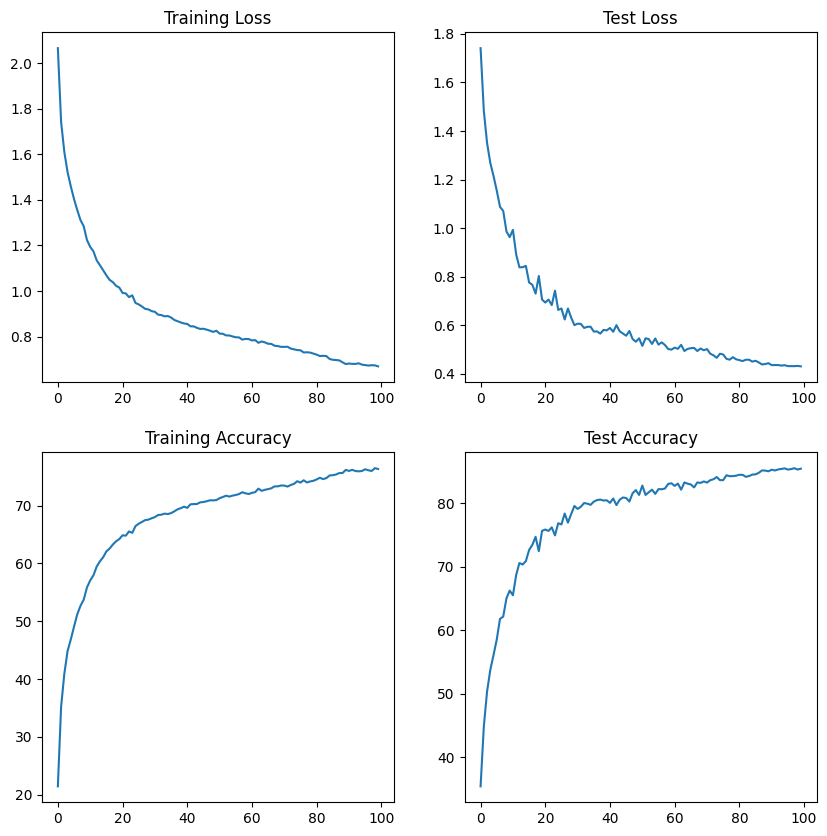

In [13]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

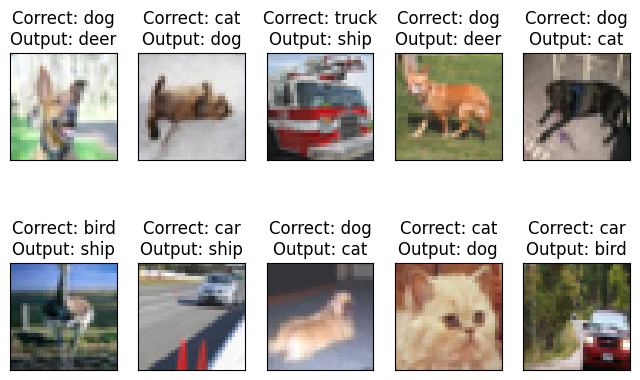

In [14]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=10)